# Exercise 4: PGA calculations using different GMPE for Antananarivo

This notebook demonstrates a workflow for analyzing earthquake hazard in the region surrounding Antananarivo, Madagascar. The main steps include:

1. **Defining the Scenario**  
    The city of interest (`CITY_NAME`) is Antananarivo, with coordinates (`CITY_LAT`, `CITY_LON`). The study area is defined by a bounding box (`MIN_LAT`, `MAX_LAT`, `MIN_LON`, `MAX_LON`) and a minimum earthquake magnitude (`MIN_MAG`).

2. **Fetching Earthquake Data**  
    Earthquake events are retrieved from the USGS catalog using ObsPy, covering the specified region and time period (`START_DATE` to `END_DATE`). Events are filtered to ensure valid depth and magnitude information.

3. **Calculating Distances**  
    For each event, the epicentral and hypocentral distances from Antananarivo are computed using the haversine formula and depth information.

4. **Estimating Ground Shaking (PGA)**  
    Several empirical attenuation models are applied to estimate Peak Ground Acceleration (PGA) for each event:
    - Joyner & Boore (1981)
    - Campbell (1981)
    - Fukushima & Tanaka (1990)

5. **Intensity Conversion**  
    PGA values are converted to Modified Mercalli Intensity (MMI) using a standard relationship.

6. **Visualization**  
    The results are visualized with histograms of PGA values and scatter plots of PGA versus distance for each attenuation model.

This exercise provides hands-on experience with earthquake catalog data, ground motion prediction equations, and hazard visualization, using Python scientific libraries and geospatial tools.

First, we need to install the required packages.

In [15]:
# 1) Install dependencies if missing
import sys, subprocess, importlib

def ensure(pkg, import_name=None):
    name = import_name or pkg
    try:
        importlib.import_module(name)
        print(f"[ok] {pkg} already installed")
    except Exception:
        print(f"[info] Installing {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
        importlib.import_module(name)
        print(f"[ok] {pkg} installed")


pkgs = ["os", "re", "requests", "zipfile", "geopandas",
        "matplotlib", "shapely", "cartopy", "obspy", 
        "folium", "osmnx", "numpy", "pandas"]

for pkg in pkgs:
    ensure(pkg)

[ok] os already installed
[ok] re already installed
[ok] requests already installed
[ok] zipfile already installed
[ok] geopandas already installed
[ok] matplotlib already installed
[ok] shapely already installed
[ok] cartopy already installed
[ok] obspy already installed
[ok] folium already installed
[ok] osmnx already installed
[ok] numpy already installed
[ok] pandas already installed


# Import required libraries

In the next cell, we will import the required packages and define the parameters and constants needed for the exercise.

In [16]:
#%% Imports and constants
import numpy as np
import matplotlib.pyplot as plt
from math import radians, sin, cos, asin, sqrt, log10, log, exp
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import geopandas as gpd
import requests, zipfile, io
from obspy.geodetics import gps2dist_azimuth
import pandas as pd

# Constants
R_EARTH_KM = 6371.0  # Earth radius in kilometers

#%% Parameters (scenario definition, city location, bounding box)
# City of interest
CITY_NAME = "Antananarivo"
CITY_LAT = -18.9
CITY_LON = 47.5

# Earthquake catalog search parameters
MIN_LAT = -26.0
MAX_LAT = -11.0
MIN_LON = 42.0
MAX_LON = 51.0
START_DATE = UTCDateTime(1900, 1, 1)
END_DATE = UTCDateTime.now()
MIN_MAG = 3.0

# Fetching and Preparing Earthquake Event Data

In this step, we retrieve earthquake events from the USGS catalog using ObsPy, filtered by the defined region and magnitude threshold. Events missing depth or magnitude information are excluded to ensure data quality. For each valid event, we calculate the epicentral distance from Antananarivo using the haversine formula, and the hypocentral distance by combining epicentral distance and depth. The results are stored in a GeoDataFrame for further analysis and visualization.

In [17]:
#%% Fetch earthquake catalog using ObsPy
client = Client("USGS")
catalog = client.get_events(starttime=START_DATE, endtime=END_DATE,
                            minlatitude=MIN_LAT, maxlatitude=MAX_LAT,
                            minlongitude=MIN_LON, maxlongitude=MAX_LON,
                            minmagnitude=MIN_MAG)
print(f"Fetched {catalog.count()} earthquake events from the catalog")

# Remove events with missing depth or magnitude
catalog = [event for event in catalog if event.origins and event.magnitudes and
           event.origins[0].depth is not None and event.magnitudes[0].mag is not None]
print(f"Number of events with depth and magnitude information: {len(catalog)}")

#%% Calculate distances from city to each event
# Function to calculate haversine distance between two lat/lon points
def haversine(lat1, lon1, lat2, lon2):
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    # Haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = R_EARTH_KM * c
    return km

#%% Extract event data (latitude, longitude, depth, magnitude, distance)
# into geopandas dataframe
event_data = []
for event in catalog:
    origin = event.origins[0]
    magnitude = event.magnitudes[0].mag if event.magnitudes else None
    if origin and magnitude is not None:
        event_data.append({
            "latitude": origin.latitude,
            "longitude": origin.longitude,
            "depth_km": origin.depth / 1000.0,  # convert to km
            "magnitude": magnitude,
            "distance": haversine(CITY_LAT, CITY_LON, origin.latitude, origin.longitude),
            "hypo_dist": sqrt(haversine(CITY_LAT, CITY_LON, origin.latitude, 
                                        origin.longitude)**2 + (origin.depth / 1000.0)**2)
        })

events_gdf = gpd.GeoDataFrame(event_data, geometry=gpd.points_from_xy(
    [e["longitude"] for e in event_data],
    [e["latitude"] for e in event_data]
))

print(f"Prepared GeoDataFrame with {len(events_gdf)} events")
print(events_gdf.head())

Fetched 297 earthquake events from the catalog
Number of events with depth and magnitude information: 297
Prepared GeoDataFrame with 297 events
   latitude  longitude  depth_km  magnitude    distance   hypo_dist  \
0  -19.0881    43.7141     10.00        4.6  398.593131  398.718552   
1  -16.8068    44.1831     10.00        4.6  421.185234  421.303929   
2  -12.3766    47.2801     10.00        4.3  725.750554  725.819445   
3  -12.5780    46.2637     10.29        4.3  715.303024  715.377034   
4  -25.7980    47.3106     10.00        5.3  767.269438  767.334602   

                   geometry  
0  POINT (43.7141 -19.0881)  
1  POINT (44.1831 -16.8068)  
2  POINT (47.2801 -12.3766)  
3   POINT (46.2637 -12.578)  
4   POINT (47.3106 -25.798)  


# Ground Shaking Estimation and Intensity Conversion

In this section, we define functions to estimate Peak Ground Acceleration (PGA) for each earthquake event using several empirical attenuation models:

- **Joyner & Boore (1981)**
- **Campbell (1981)**
- **Fukushima & Tanaka (1990)**
- **Climent et al. (1994)** (optional, use with caution)

Each function takes earthquake magnitude and distance as input and returns the estimated PGA (in units of gravity, g). Additionally, we provide a function to convert PGA values to Modified Mercalli Intensity (MMI) using the Trifunac & Brady (1975) relationship. These models allow us to quantify expected ground shaking at Antananarivo for each event in the catalog.

In [18]:
#%% Calculate PGA using different attenuation models
def pga_joyner_boore_1981(M, E):
    """
    Joyner & Boore (1981) attenuation equation.
    PGA = 10^(0.249*M - log10(D) - 0.00255*D - 1.02)
    D = sqrt(E^2 + 7.3^2)
    
    Parameters
    ----------
    M : float
        Magnitude
    E : float
        Epicentral distance (km)
    
    Returns
    -------
    PGA : float
        Peak ground acceleration (in g)
    """
    D = np.sqrt(E**2 + 7.3**2)
    log10_pga = 0.249*M - np.log10(D) - 0.00255*D - 1.02
    PGA = 10**log10_pga
    return PGA


def pga_campbell_1981(M, E):
    """
    Campbell (1981) attenuation equation.
    PGA = 0.0185 * exp(1.28*M) * D^(-1.75)
    D = E + 0.147 * exp(0.732*M)
    
    Parameters
    ----------
    M : float
        Magnitude
    E : float
        Epicentral distance (km)
    
    Returns
    -------
    PGA : float
        Peak ground acceleration (in g)
    """
    D = E + 0.147*np.exp(0.732*M)
    PGA = 0.0185 * np.exp(1.28*M) * D**(-1.75)
    return PGA


def pga_fukushima_tanaka_1990(M, R):
    """
    Fukushima & Tanaka (1990) attenuation equation.
    PGA = (10^(0.41*M - log10(R + 0.032*10^(0.41*M) - 0.0034*R + 1.30))) / 980
    
    Parameters
    ----------
    M : float
        Magnitude
    R : float
        Hypocentral distance (km)
    
    Returns
    -------
    PGA : float
        Peak ground acceleration (in g)
    """
    log10_term = 0.41*M - np.log10(R + 0.032*(10**(0.41*M)) - 0.0034*R + 1.30)
    PGA = (10**log10_term) / 980.0
    return PGA

def pga_climent_1994(M, R, S=0):
    """
    Climent et. al. (1994) attenuation relation.
    Refer to the original paper for details.
    The equation leads to unrealistically high PGA values for small R.
    Use with caution.

    ln(PGA) = -1.687 + (0.553*M) - (0.537*ln(R)) - (0.00302*R) + (0.327*S)
    PGA = exp(ln(PGA))
    
    Parameters
    ----------
    M : float
        Earthquake magnitude
    R : float
        Distance (km) - consistent with model definition
    S : int or float, optional
        Site term (default=0, for rock)
    
    Returns
    -------
    PGA : float
        Peak ground acceleration (in g), rounded to 3 decimals
    """
    ln_pga = -1.687 + (0.553*M) - (0.537*np.log(R)) - (0.00302*R) + (0.327*S)
    PGA = np.exp(ln_pga)
    return np.round(PGA, 3)


def mmi_from_pga(PGA):
    """
    Convert PGA (in g) to MMI using Trifunac & Brady (1975).
    MMI = (1/0.3) * (log10(PGA*980) - 0.014)
    
    Parameters
    ----------
    PGA : float
        Peak ground acceleration (in g)
    
    Returns
    -------
    MMI : float
        Modified Mercalli Intensity
    """
    return (np.log10(PGA*980) - 0.014) / 0.3

# PGA Calculation and Visualization

In this step, we estimate the Peak Ground Acceleration (PGA) for each earthquake event in the catalog using three different empirical attenuation models: Joyner & Boore (1981), Campbell (1981), and Fukushima & Tanaka (1990). The calculated PGA values are added to the GeoDataFrame (`events_gdf`) for each event. We also convert these PGA values to Modified Mercalli Intensity (MMI) for a qualitative measure of shaking.

To visualize the results, we plot histograms of PGA values for each model. These histograms show the distribution of expected ground shaking at Antananarivo from regional earthquakes, allowing comparison between the different attenuation relationships.


Calculated PGA for each event
   magnitude    distance  depth_km  pga_joyboo  pga_campbell  pga_fukushima
0        4.6  398.593131     10.00    0.000322      0.000184       0.000196
1        4.6  421.185234     10.00    0.000267      0.000167       0.000185
2        4.3  725.750554     10.00    0.000022      0.000044       0.000081
3        4.3  715.303024     10.29    0.000024      0.000046       0.000083
4        5.3  767.269438     10.00    0.000029      0.000144       0.000197
   magnitude    distance  depth_km  mmi_joyboo  mmi_campbell  mmi_fukushima
0        4.6  398.593131     10.00   -1.715198     -2.524960      -2.437596
1        4.6  421.185234     10.00   -1.986986     -2.663191      -2.516632
2        4.3  725.750554     10.00   -5.612136     -4.583995      -3.707464
3        4.3  715.303024     10.29   -5.502348     -4.547435      -3.686577
4        5.3  767.269438     10.00   -5.215557     -2.883410      -2.426457


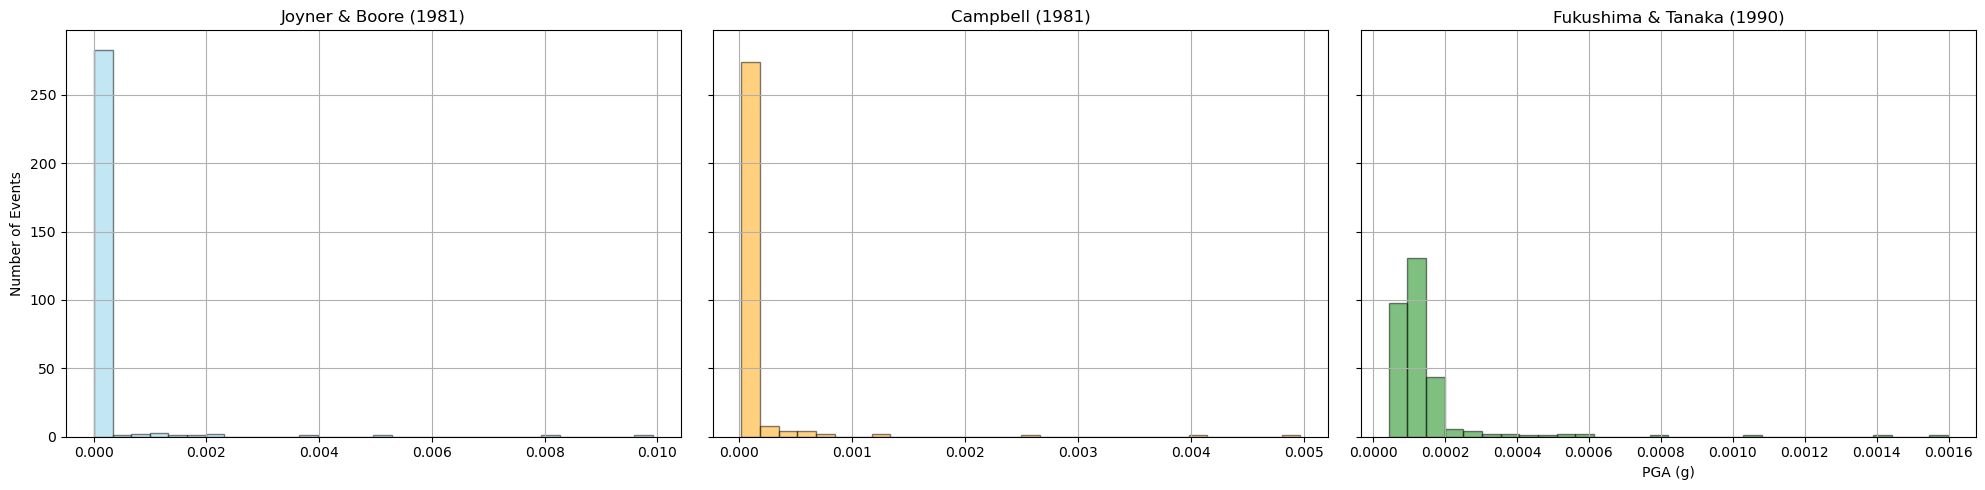

In [19]:
#%% Calculate PGA for each event using the different models and store in the GeoDataFrame
events_gdf['pga_joyboo'] = events_gdf.apply(lambda row: pga_joyner_boore_1981(row['magnitude'], 
                                     row['distance']), axis=1)
events_gdf['pga_campbell'] = events_gdf.apply(lambda row: pga_campbell_1981(row['magnitude'], 
                                     row['distance']), axis=1)
events_gdf['pga_fukushima'] = events_gdf.apply(lambda row: pga_fukushima_tanaka_1990(row['magnitude'], 
                                     row['hypo_dist']), axis=1)

events_gdf['mmi_joyboo'] = events_gdf['pga_joyboo'].apply(mmi_from_pga)
events_gdf['mmi_campbell'] = events_gdf['pga_campbell'].apply(mmi_from_pga)
events_gdf['mmi_fukushima'] = events_gdf['pga_fukushima'].apply(mmi_from_pga)

print("Calculated PGA for each event")
print(events_gdf[['magnitude', 'distance', 'depth_km', 'pga_joyboo', 'pga_campbell', 'pga_fukushima']].head())
print(events_gdf[['magnitude', 'distance', 'depth_km', 'mmi_joyboo', 'mmi_campbell', 'mmi_fukushima']].head())

# Plot histogram of PGA values for each model in a figure of 1 * 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

axs[0].hist(events_gdf['pga_joyboo'], bins=30, color='skyblue', 
            edgecolor='black', alpha=0.5)
axs[0].set_title('Joyner & Boore (1981)')
axs[0].set_ylabel('Number of Events')
axs[0].grid()

axs[1].hist(events_gdf['pga_campbell'], bins=30, color='orange', 
            edgecolor='black', alpha=0.5)
axs[1].set_title('Campbell (1981)')
axs[1].grid()

axs[2].hist(events_gdf['pga_fukushima'], bins=30, color='green', 
            edgecolor='black', alpha=0.5)
axs[2].set_title('Fukushima & Tanaka (1990)')
axs[2].set_xlabel('PGA (g)')
axs[2].grid()

plt.tight_layout()
plt.show()

# PGA vs Distance Scatter Plots

The figure below shows scatter plots of Peak Ground Acceleration (PGA) versus epicentral distance for each earthquake event in the catalog, using three different attenuation models:

- **Joyner & Boore (1981)**
- **Campbell (1981)**
- **Fukushima & Tanaka (1990)**

Each point represents an earthquake, with its distance from Antananarivo on the x-axis and the estimated PGA (in units of gravity, g) on the y-axis (logarithmic scale). Comparing the models reveals differences in predicted ground shaking for events at various distances. These plots help visualize how ground motion attenuates with distance and highlight the variability between empirical relationships.

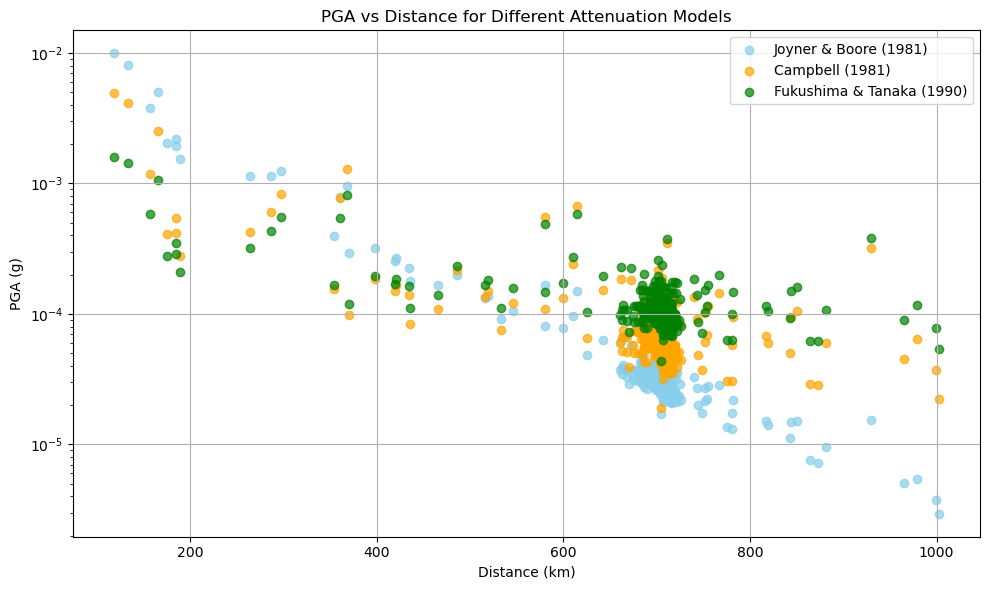

In [20]:
#%% Make PGA vs distance plots for each model
plt.figure(figsize=(10, 6))
plt.scatter(events_gdf['distance'], events_gdf['pga_joyboo'], color='skyblue', 
            label='Joyner & Boore (1981)', alpha=0.7)
plt.scatter(events_gdf['distance'], events_gdf['pga_campbell'], color='orange', 
            label='Campbell (1981)', alpha=0.7)
plt.scatter(events_gdf['distance'], events_gdf['pga_fukushima'], color='green', 
            label='Fukushima & Tanaka (1990)', alpha=0.7)
plt.yscale('log')

plt.xlabel('Distance (km)')
plt.ylabel('PGA (g)')
plt.title('PGA vs Distance for Different Attenuation Models')
plt.legend()    
plt.grid()
plt.tight_layout()
plt.show()


# Extra tasks:
* What are your observations about the different GMPEs?
* Try the Climent et al. (1994) equation. What are your observations about the estimations from this relation?
* Referring to the original paper by Climent et al. (1994) ([link](https://www.researchgate.net/publication/261216258_New_spectral_strong_motion_attenuation_models_for_Central_America)), what are your observations about the approximation of the regression factors?
* Try replacing E with R in all equations and compare the results.
